In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import sys
print(sys.version)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy


from utils import *
from models import *
from fid_score import *
from inception_score import *

from real_imgs import *

3.9.5 (v3.9.5:0a7dcbdb13, May  3 2021, 13:17:02) 
[Clang 6.0 (clang-600.0.57)]
['/Users/ryomacmini/work/codes/MNIST_Calculator/calculator', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.9.1101343141/pythonFiles', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.9.1101343141/pythonFiles/lib/python', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/IPython/extensions', '/Users/ryomacmini/.ipython']


# ロードした画像の表示を試す。
(1)ローカルにある画像を表示すること<br>
(2)RGBではなくグレースケールにすること<br>
(3)28.28にreshapeすること→なぜかRGB最小が0にならなかったので、そもそも28pixで画像を準備<br>

PNG (28, 28) RGBA
((0, 255), (0, 255), (0, 255), (255, 255))
(255, 255, 255, 255)


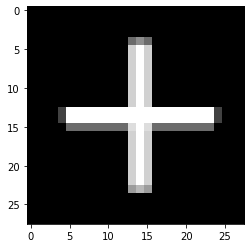

In [5]:
from PIL import Image, ImageFilter

im = Image.open('img/addition28pix.png')
plt.imshow(np.array(im))
print(im.format, im.size, im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(im.getextrema()) #RGB各色の最小値と最大値を取得。
print(im.getpixel((14,14 ))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

None (28, 28) L
(0, 255)
255


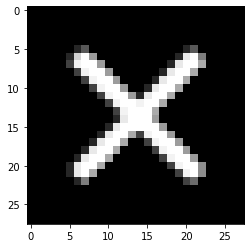

In [6]:
im2 = Image.open('img/multiplication28pix.png')
new_im = im2.convert('L')
plt.imshow(np.array(new_im), cmap='gray')
print(new_im.format, new_im.size, new_im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(new_im.getextrema()) #RGB各色の最小値と最大値を取得。
print(new_im.getpixel((14, 14))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

None (28, 28) L
(0, 255)
0


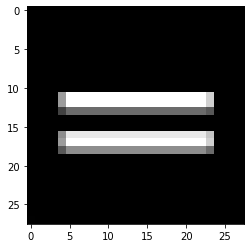

In [7]:
im3 = Image.open('img/equal28pix.png')
im3 = im3.convert('L')
im3 = im3.resize((28, 28))
plt.imshow(np.array(im3), cmap='gray')

print(im3.format, im3.size, im3.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(im3.getextrema()) #RGB各色の最小値と最大値を取得。
print(im3.getpixel((12, 10))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

### ＜参考＞resizeしたら、最小となっているところが"0"=完全黒にならなかった

None (28, 28) L
(12, 255)
255


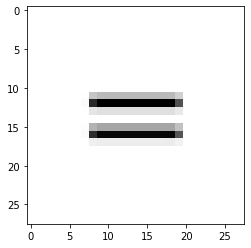

In [8]:
im4 = Image.open('img/equal.png')
im4 = im4.convert('L')
im4 = im4.resize((28, 28))
plt.imshow(np.array(im4), cmap='gray')

print(im4.format, im4.size, im4.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
#None (28, 28) L

print(im4.getextrema()) #RGB各色の最小値と最大値を取得。
#(12, 255)

print(im4.getpixel((1, 1))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。
#255

# MNISTから画像を表示してみる

### データをダウンロードする

In [9]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### trainloaderの中身を見る

In [10]:
data_iter = iter(trainloader)
images, labels = data_iter.next()

<built-in method type of Tensor object at 0x7fd5d888e800>
torch.Size([60000, 1, 28, 28])
60000
------------------------
<built-in method type of Tensor object at 0x7fd5d888ec00>
torch.Size([60000])
60000
------------------------
torch.Size([1, 28, 28])
------------------------
Label: tensor(5)


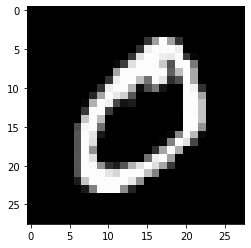

In [11]:
# matplotlibで1つ目のデータを可視化してみる
print(images.type)
print(images.size())
print(len(images))
print("------------------------")
print(labels.type)
print(labels.size())
print(len(labels))
print("------------------------")
print(images[1].size())
print("------------------------")
npimg = images[1].numpy()
npimg = npimg.reshape((28, 28))
plt.imshow(npimg, cmap='gray')
print('Label:', labels[0])

### testloaderの中身を見る

In [12]:
testloader_iter= iter(testloader)
images2, labels2 = testloader_iter.next()

<built-in method type of Tensor object at 0x7fd5d8867480>
torch.Size([10000, 1, 28, 28])
10000
------------------------
<built-in method type of Tensor object at 0x7fd5b8f87740>
torch.Size([10000])
10000
------------------------
torch.Size([1, 28, 28])
------------------------
Label: tensor(7)


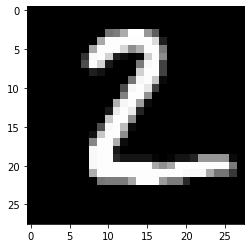

In [13]:
# matplotlibで1つ目のデータを可視化してみる
print(images2.type)
print(images2.size())
print(len(images2))
print("------------------------")
print(labels2.type)
print(labels2.size())
print(len(labels2))
print("------------------------")
print(images2[1].size())
print("------------------------")
npimg2 = images2[1].numpy()
npimg2 = npimg2.reshape((28, 28))
plt.imshow(npimg2, cmap='gray')
print('Label:', labels2[0])

# 学習データを作るための試行錯誤

### 桁数をコントロールする方法をマスターする

※（かえるのアドバイス）
pythonのパディングという操作があるよ！

In [14]:
X_digit = 1
Y_digit = 1
result_digit = 2

X = random.randrange(10**(X_digit-1),10**X_digit) #指定の桁数の中で乱数が出る
Y = random.randrange(10**(Y_digit-1),10**Y_digit) #指定の桁数の中で乱数が出る
Z = str(X*Y).zfill(result_digit)

print(X,Y,Z)
print(type(X),type(Y),type(X))
print('Xの桁数は',len(str(X)),\
      'Yの桁数は',len(str(Y)),\
      'Zの桁数は',len(str(Z)))

8 9 72
<class 'int'> <class 'int'> <class 'int'>
Xの桁数は 1 Yの桁数は 1 Zの桁数は 2


### 数字を指定すれば、指定の画像が取ってこれるようになろう

In [15]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))

trainloader_iter = iter(trainloader)
train_images, train_labels = trainloader_iter.next()


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


In [16]:
MNIST_dict = {i: [] for i in range(10)}
MNIST_dict

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [17]:
for i in range(len(train_images)):
    if train_labels[i] == 0:
        MNIST_dict[0].append(train_images[i])
    if train_labels[i] == 1:
        MNIST_dict[1].append(train_images[i])
    if train_labels[i] == 2:
        MNIST_dict[2].append(train_images[i])
    if train_labels[i] == 3:
        MNIST_dict[3].append(train_images[i])
    if train_labels[i] == 4:
        MNIST_dict[4].append(train_images[i])
    if train_labels[i] == 5:
        MNIST_dict[5].append(train_images[i])
    if train_labels[i] == 6:
        MNIST_dict[6].append(train_images[i])
    if train_labels[i] == 7:
        MNIST_dict[7].append(train_images[i])
    if train_labels[i] == 8:
        MNIST_dict[8].append(train_images[i])
    if train_labels[i] == 9:
        MNIST_dict[9].append(train_images[i])

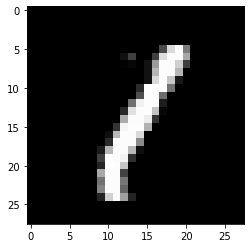

In [18]:
test1 = MNIST_dict[1][1000].numpy()
test1 = test1.reshape((28, 28))
plt.imshow(test1, cmap='gray')

In [203]:
print(len(MNIST_dict[0]))
print(len(MNIST_dict[1]))
print(len(MNIST_dict[2]))
print(len(MNIST_dict[3]))
print(len(MNIST_dict[4]))
print(len(MNIST_dict[5]))
print(len(MNIST_dict[6]))
print(len(MNIST_dict[7]))
print(len(MNIST_dict[8]))
print(len(MNIST_dict[9]))

5923
6742
5958
6131
5842
5421
5918
6265
5851
5949


In [468]:
random_get(0)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  13., 118., 253., 253., 253., 127.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0

### ランダムに画像を指定して持ってくる（何桁でも行けるように関数を書き換える）

In [300]:
s = 1357
print(len(list(str(s))))
print(type(len(list(str(s)))))

print(list(str(s)))
print(type(list(str(s))))

print(list(str(s))[0])
print(list(str(s))[1])
print(list(str(s))[2])
print(type(list(str(s)))[1])

print(range(len(list(str(s)))))

for i in range(len(list(str(s)))):
    print(list(str(s))[i])

4
<class 'int'>
['1', '3', '5', '7']
<class 'list'>
1
3
5
list[1]
range(0, 4)
1
3
5
7


In [467]:
def random_get(figure):
    random_num = random.randrange(len(MNIST_dict[figure]))
    random_get = MNIST_dict[figure][random_num].numpy()
    random_get = random_get.reshape((28, 28))
    return random_get*255 #255を乗算しないと、floatのままになり、後にくるインポート画像とconcatinate出来ない

In [ ]:
def random_get2(figure):
    for i in range(len(str(figure))):
        figure_i_num = int(list(str(figure))[i])
        random_num = random.randrange(len(MNIST_dict[figure_i_num]))
        random_get = MNIST_dict[figure_i_num][random_num].numpy()
        random_get = random_get.reshape((28, 28))
        plt.imshow(random_get, cmap='gray')
        print('生成した画像番号は',random_num)
        break

### 後にconcatすることを考えたら、関数の外で一の位から入力されていった方が良いだろうか

In [ ]:
figure = 4649
train_img_list = []

for i in range(len(str(figure))):
    figure_i_num = int(list(str(figure))[i])
    img = random_get(figure_i_num)
    train_img_list.append(img)

train_img_list = cv2.hconcat(train_img_list)
cv2.imwrite('train_img/trainX.jpg', train_img_list)

[array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   

True

### ようやくX,Yを何桁にしても画像がひっつくようになったので、記号も付けられるようにしていく。

In [ ]:
X_digit = 2
Y_digit = 2
result_digit = len(str(int('9'*X_digit) * int('9'*X_digit)))
print(result_digit)

multi_img = Image.open('img/multiplication28pix_small.jpg')
multi_img = np.array(multi_img)
print(multi_img.size)
print(multi_img.shape)

add_img = Image.open('img/addition28pix_small.jpg')
add_img = np.array(add_img)
print(add_img.size)
print(add_img.shape)

equal_img = Image.open('img/equal28pix_small.jpg')
equal_img = np.array(equal_img)
print(equal_img.size)
print(equal_img.shape)


X = random.randrange(10**(X_digit-1),10**X_digit) #指定の桁数の中で乱数が出る
Y = random.randrange(10**(Y_digit-1),10**Y_digit) #指定の桁数の中で乱数が出る
Z = str(X*Y).zfill(result_digit)

print(X,Y,Z)
print(type(X),type(Y),type(X))
print('Xの桁数は',len(str(X)),\
      'Yの桁数は',len(str(Y)),\
      'Zの桁数は',len(str(Z)))




4


### どうも、画像としてインポートしたデータと、MNISTだと次元数とか厳密に異なってしまってうまく行っていない感じ。

In [ ]:
train_img_list = []
for i in range(len(str(X))):
    figure_X_num = int(list(str(X))[i])
    img = random_get(figure_X_num)
    train_img_list.append(img)
train_img_list.append(multi_img)

for i in range(len(str(Y))):
    figure_Y_num = int(list(str(Y))[i])
    img = random_get(figure_Y_num)
    train_img_list.append(img)
train_img_list.append(add_img)

for i in range(len(str(Z))):
    figure_Z_num = int(list(str(Z))[i])
    img = random_get(figure_Z_num)
    train_img_list.append(img)

train_img_list = cv2.hconcat(train_img_list)
cv2.imwrite('train_img/trainX.jpg', train_img_list)


###
# ---------------------------------------------------------------------------
# error                                     Traceback (most recent call last)
# /var/folders/cs/y7bb9xyj3291t5pd4_0j9kp80000gn/T/ipykernel_7644/1500508036.py in <module>
#      17     train_img_list.append(img)
#      18 
# ---> 19 train_img_list = cv2.hconcat(train_img_list)
#      20 cv2.imwrite('train_img/trainX.jpg', train_img_list)

# error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/core/src/matrix_operations.cpp:67: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'
###


error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/core/src/matrix_operations.cpp:67: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'hconcat'


### 調査する

In [ ]:
X = 1

train_img_list = []
for i in range(len(str(X))):
    figure_X_num = int(list(str(X))[i])
    img = random_get(figure_X_num).astype(np.uint8)
    print('次元数',img.ndim)
    print('shape',img.shape)
    train_img_list.append(img)
print('データ',train_img_list)
print('タイプ',type(train_img_list))


print('データ',multi_img.astype(np.uint8))
print('次元数',multi_img.ndim)
print('shape',multi_img.shape)
print('タイプ',type(multi_img))


次元数 2
shape (28, 28)
データ [array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         64, 255, 191,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

### MNISTをuint8（8ビット符号なし整数）に変換するようにしたら、concat出来た

In [ ]:
train_img_list = []
for i in range(len(str(X))):
    figure_X_num = int(list(str(X))[i])
    img = random_get(figure_X_num).astype(np.uint8)
    train_img_list.append(img)
train_img_list.append(multi_img)

train_img_list = cv2.hconcat(train_img_list)
cv2.imwrite('train_img/trainX.jpg', train_img_list)

True

### npyで保存も試しておく。

In [ ]:
np.save('train_img/train_data_array', np.array(train_data_array))
np.save('train_img/train_data_array_float32', np.array(train_data_array).astype('float32'))

In [ ]:
a = np.load('train_img/train_data_array.npy')
print(a.dtype)
print(type(a))
print(a.shape)

a_float32 = np.load('train_img/train_data_array_float32.npy')
print(a_float32.dtype)
print(type(a_float32))
print(a_float32.shape)


uint8
<class 'numpy.ndarray'>
(10, 28, 392)
float32
<class 'numpy.ndarray'>
(10, 28, 392)


# 学習データ作成・保存部分

### ようやく結合。<br>

In [2]:
#MNIST画像をダウンロード
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)

trainloader_iter = iter(trainloader)
train_images, train_labels = trainloader_iter.next()

/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#0-9までの空配列を作る
MNIST_dict = {i: [] for i in range(10)}

#数字に別々の配列に格納していく。
for i in range(len(train_images)):
    if train_labels[i] == 0:
        MNIST_dict[0].append(train_images[i])
    if train_labels[i] == 1:
        MNIST_dict[1].append(train_images[i])
    if train_labels[i] == 2:
        MNIST_dict[2].append(train_images[i])
    if train_labels[i] == 3:
        MNIST_dict[3].append(train_images[i])
    if train_labels[i] == 4:
        MNIST_dict[4].append(train_images[i])
    if train_labels[i] == 5:
        MNIST_dict[5].append(train_images[i])
    if train_labels[i] == 6:
        MNIST_dict[6].append(train_images[i])
    if train_labels[i] == 7:
        MNIST_dict[7].append(train_images[i])
    if train_labels[i] == 8:
        MNIST_dict[8].append(train_images[i])
    if train_labels[i] == 9:
        MNIST_dict[9].append(train_images[i])

In [63]:
# X　✕　Y　= Z という式の画像が保存されるので、最初に必要なものを記述する

image_output_dir = "train_img/" #出力先のディレクトリを指定
number_of_output = 50000 #出力する枚数を指定
npy_uint8_filename = 'train_data_array'
npy_float32_filename = 'train_data_array_float32'

X_digit = 3 #Xの桁数を指定
Y_digit = 3 #Yの桁数を指定

#--------------------ここからは変更する必要なし--------------------#

result_digit = len(str(int('9'*X_digit) * int('9'*Y_digit))) #Zの桁数を計算。ゼロパティングのための計算。

multi_img = Image.open('img/multiplication28pix_small.jpg') #計算記号「✕」をロードする
multi_img = np.array(multi_img.convert('L')) #グレイスケールへ変換

add_img = Image.open('img/addition28pix_small.jpg') #計算記号「+」をロードする
add_img = np.array(add_img.convert('L')) #グレイスケールへ変換

equal_img = Image.open('img/equal28pix_small.jpg') #計算記号「=」をロードする
equal_img = np.array(equal_img.convert('L')) #グレイスケールへ変換

train_data_array = [] #.npyで保存するための配列

def random_get(figure): #引数として数字を指定したら、指定数字のMNIST画像をランダムで取ってくる（ndarray）
    random_num = random.randrange(len(MNIST_dict[figure])) #MNISTの指定数字は何枚入っているのかを見る
    random_get = MNIST_dict[figure][random_num].numpy()
    random_get = random_get.reshape((28, 28))
    return random_get*255 #255を乗算しないと、floatのままになり、後にくるインポート画像とconcatinate出来ない

for k in range(number_of_output): 
    X = random.randrange(10**(X_digit-1),10**X_digit) #指定の桁数の中で乱数が出る
    Y = random.randrange(10**(Y_digit-1),10**Y_digit) #指定の桁数の中で乱数が出る
    Z = str(X*Y).zfill(result_digit)
    train_img_list = []

    for i in range(len(str(X))):
        figure_X_num = int(list(str(X))[i])
        img = random_get(figure_X_num).astype(np.uint8)
        train_img_list.append(img)

    train_img_list.append(multi_img) #「✕」の記号をXにくっつける

    for i in range(len(str(Y))):
        figure_Y_num = int(list(str(Y))[i])
        img = random_get(figure_Y_num).astype(np.uint8)
        train_img_list.append(img)

    train_img_list.append(equal_img)

    for i in range(len(str(Z))):
        figure_Z_num = int(list(str(Z))[i])
        img = random_get(figure_Z_num).astype(np.uint8)
        train_img_list.append(img)

    train_img_list = cv2.hconcat(train_img_list)
    train_data_array.append(train_img_list) #.npyで保存するための配列に追加していく

np.save(image_output_dir + npy_uint8_filename, np.array(train_data_array))
np.save(image_output_dir + npy_float32_filename, np.array(train_data_array).astype('float32'))

    # 画像で保存したい場合は、下記をアンコメントする
    # cv2.imwrite(image_output_dir + str(k) + '.jpg', train_img_list)

In [67]:
a = np.load('train_img/train_data_array.npy')
print(a.dtype)
print(type(a))
print(a.shape)

a_float32 = np.load('train_img/train_data_array_float32.npy')
print(a_float32.dtype)
print(type(a_float32))
print(a_float32.shape)

uint8
<class 'numpy.ndarray'>
(10, 28, 392)
float32
<class 'numpy.ndarray'>
(10, 28, 392)


# その他、試行錯誤

### 保存先を指定する

In [ ]:
# image_output_dir = "/content/drive/MyDrive/ryo/99.data/train_data/"
image_output_dir = "train_img/"
img123_hconcat = cv2.hconcat(im_list)
type(img123_hconcat)
pil_img = Image.fromarray(img123_hconcat)
print(pil_img.mode)
pil_img.save(image_output_dir + 'hconcat_test.jpg')

In [ ]:
pil_img.save(image_output_dir + 'hconcat_test.jpg')

### 画像を開いてみる

None (28, 28) L
(0, 255)
255


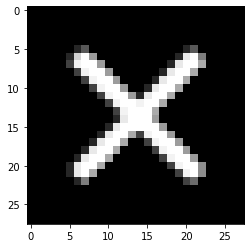

In [ ]:
im2 = Image.open('img/multiplication28pix.png')
new_im = im2.convert('L')
plt.imshow(np.array(new_im), cmap='gray')
print(new_im.format, new_im.size, new_im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(new_im.getextrema()) #RGB各色の最小値と最大値を取得。
print(new_im.getpixel((14, 14))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

### 画像を取得し、Tensorへ変換する

In [ ]:
img1 = Image.open('img/multiplication28pix.png')
img1_tensor = torchvision.transforms.functional.to_tensor(img1)
# plt.imshow(np.array(img1), cmap='gray')

img2 = Image.open('img/addition28pix.jpg')
img2_tensor = torchvision.transforms.functional.to_tensor(img2)
# plt.imshow(np.array(img2), cmap='gray')

img3 = Image.open('img/equal28pix.jpg')
img3_tensor = torchvision.transforms.functional.to_tensor(img3)
# plt.imshow(np.array(img3), cmap='gray')

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

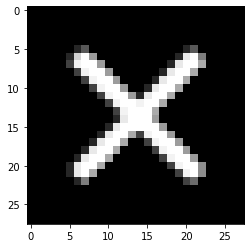

In [ ]:
plt.imshow(img1_tensor[0],cmap="gray")
plt.savefig("test.png")

### Tensorから画像に戻してみる

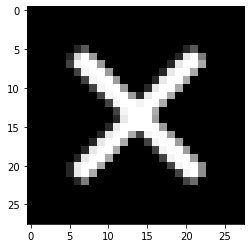

In [ ]:
img1_PIL = torchvision.transforms.functional.to_pil_image(img1_tensor)
# img1_PIL.show
plt.imshow(img1_PIL, cmap='gray')

### Tensorを画像として保存する

2つとも試したけどだめだった。エラーは同じ。
```
torchvision.utils.save_image(img3_tensor,'img_tensor3.jpg')　←　tensorをtorchvisionを使って画像化
img1_PIL.save("img1_PIL.jpg","JPEG",quality=95)　← PILをつかって、JPEGを保存する

OSError: cannot write mode RGBA as JPEG
```

結論、.pngを読み込むと、TensorがRGBAになってしまい、各ライブラリの保存形式では保存ができないということが起きた。


In [ ]:
#どっちでも行けるんだけど、PILよりtorchvisionで出来る方を採用しよう。
# img1_PIL.save("img1_PIL.jpg","JPEG")
torchvision.utils.save_image(img3_tensor,'train_img/img_tensor3.jpg')

ちなみにPNGで取得しても、後でRGB変換をすれば、上記save機能で保存出来る。
```
from PIL import Image
img1_PIL = img1_PIL.convert("RGB")
img1_PIL.save("img1_PIL.jpg","JPEG",quality=95)
```

### 画像を横方向にくっつけていく
参考文献：https://roshiago.blog.ss-blog.jp/2019-07-15　<br>
https://note.nkmk.me/python-opencv-hconcat-vconcat-np-tile/<br>
<br>
Pillowでも出来そうだったんだけど、concatみたいな便利なメソッドは無さそうで<br>
1つの大きな画像を作って、そこに上から位置を決めてペーストしていく、っていう面倒な感じに見えたからやめた<br>

In [ ]:
img1 = Image.open('img/multiplication28pix.jpg')
img1 = np.array(img1)

img2 = Image.open('img/addition28pix.jpg')
img2 = np.array(img2)

img3 = Image.open('img/equal28pix.jpg')
img3 = np.array(img3)

im_list = [img1,img2,img3]

In [ ]:
img123_hconcat = cv2.hconcat(im_list)
cv2.imwrite('train_img/img123_hconcat.jpg', img123_hconcat)

True

### google drive への保存は、結構面倒なことが判明。colabへSSHして、ローカルに保存するように保存しよう。<br>
<br>
● SSHでvscodeから接続できるようにする<br>
● 生成した画像を保存する
● git cloneでcolaboのローカルにmnist_calculatorを利用できるようにする<br>
<br>
<br>
<br>


In [ ]:
# image_output_dir = "/content/drive/MyDrive/ryo/99.data/train_data/"
image_output_dir = "train_img/"
img123_hconcat = cv2.hconcat(im_list)
type(img123_hconcat)
pil_img = Image.fromarray(img123_hconcat)
print(pil_img.mode)
pil_img.save(image_output_dir + 'hconcat_test.jpg')

○画像をくっつけて学習データとして使えるようにする<br>
　○　ランダムに生成した画像を✕=の記号と組み合わせる<br>
　○　大量に保存する　<br>